# Восстановление золота из руды

## Постановка задачи

### Описание проекта

Разработать прототип модели машинного обучения, предсказывающей коэффициент восстановления золота из золотосодержащей руды. Модель позволит для последующей разработки отбирать только скважины, отличающиеся прибыльными характеристиками.

### Описание технологического процесса

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

Опишем каждую стадию:
1. Флотация. Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов. На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка. Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

#### Описание данных

**Технологический процесс**

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

#### Наименование признаков
Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`
Пример: `rougher.input.feed_ag`

**Возможные значения для блока `[этап]`:**
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

**Возможные значения для блока `[тип_параметра]`:**
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики


### Источники данных

Данные находятся в трёх файлах:

- gold_recovery_train_new.csv — обучающая выборка;
- gold_recovery_test_new.csv — тестовая выборка;
- gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.


**Расчёт эффективности**
<a id='rec'></a>

Эффективность обогащения рассчитывается по формуле (см.ниже), 

$$
 \large Recovery = \frac {\large C * (F - T)}{\large F * (C - T)}  * 100 \%
$$

где
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.


### Метрика качества

<a name='smape'></a>Вам пригодятся формулы метрик качества. Для решения задачи введём новую метрику качества — sMAPE. Она одинаково учитывает масштаб и целевого признака, и предсказания. 
$$
 \large sMAPE = \frac {1}{N} \sum_{i=1}^N \frac {|y_i - \stackrel\frown{y_i}|}{(|y_i| + \stackrel\frown{|y_i|})/ 2} * 100 \%
$$

Обозначения:
- $y_i $ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
- $\stackrel\frown{y_i}$ - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.
- $N$ - количество объектов в выборке.
- $\sum_{i=1}^N$ - cуммирование по всем объектам выборки (i меняется от 1 до N).

Нужно спрогнозировать сразу две величины:

- эффективность обогащения чернового концентрата  `rougher.output.recovery`;
- эффективность обогащения финального концентрата  `final.output.recovery`.

Итоговая метрика складывается из двух величин:

<div>
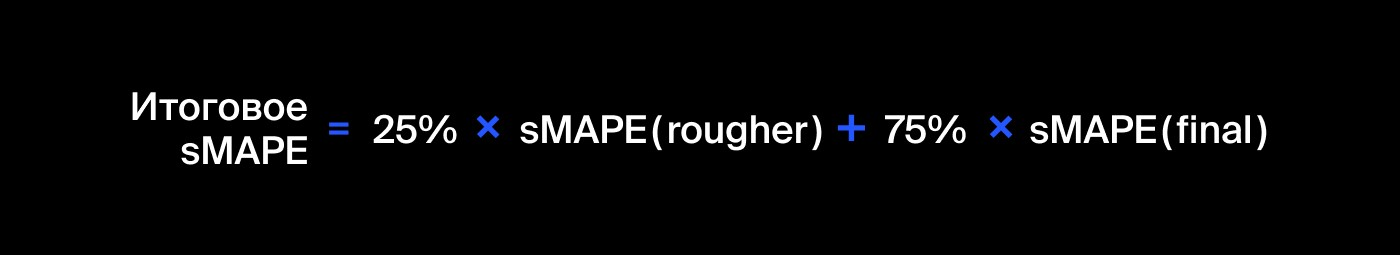
</div>

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv', parse_dates=['date'], index_col='date')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv', parse_dates=['date'], index_col='date')
full_data = pd.read_csv('/datasets/gold_recovery_full_new.csv', parse_dates=['date'], index_col='date')

### Первичный анализ

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

Видим, что в некоторых столбцах таблицы train отсутствуют значения.

In [4]:
train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

В таблице test также есть отсутствующие значения, но их значительно меньше.

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

Аналогично и в таблице full_data присутствуют пустые значения в столбцах. Количество строк в таблице full_data совпадает с суммой строк в таблицах train и test.

In [8]:
full_data.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### Эффективность обогащения

Рассчитаем значение эффективности обогащения по входным дпнным согласно формуле(см.выше) и сравним со значением в столбце `rougher.output.recovery`

In [9]:
train['verification'] = train['rougher.output.concentrate_au'] * (train['rougher.input.feed_au'] -
            train['rougher.output.tail_au']) / (train['rougher.input.feed_au'] * (train['rougher.output.concentrate_au'] -
                                train['rougher.output.tail_au'])) * 100

Рассчитаем значение метрики качества MAE

In [10]:
mae = abs(train['verification'] - train['rougher.output.recovery']).sum() / len(train['verification'])
mae

9.73512347450521e-15

Полученное значение метрики MAE показывает, что различие между рассчитанным значением эффективности обогащеня и тем, что содержится в столбце `rougher.output.recovery` очень мало. В среднем ошибка на каждом эксперименте $= 9,7*10^{-15}$. Формула верна.

### Аудит признаков

Проанализируем наличие признаков в тестовой и обучающей выборке

In [4]:
extra_signs = set(train.columns) - set(test.columns)
extra_signs

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Получился список из признаков, которые в рамках процесса получают постфактум. Их нельзя использовать для обучения модели. Удалим все столбцы, соотвествующие этим признакам, из таблицы train кроме `rougher.output.recovery`, `final.outaput.recovery`.

In [5]:
train.drop(list(extra_signs - {'rougher.output.recovery', 'final.output.recovery'}), axis=1, inplace=True)

Кроме того, в таблице присутствуют признаки, отражающие текущее состояние флотационных установок. Так как они не влияют на результаты и пояляются только в процессе обогащения, также удалим их из таблицы.  

In [6]:
train.drop(train.columns[train.columns.str.contains('state')].to_list(), axis=1, inplace=True)
train.columns

Index(['final.output.recovery', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.recovery'],
      dtype='object')

In [14]:
train.shape

(14149, 16)

С признаками в тестовой выборке поступим аналогичным образом

In [7]:
test.drop(test.columns[test.columns.str.contains('state')].to_list(), axis=1, inplace=True)
test.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate'],
      dtype='object')

In [16]:
test.shape

(5290, 14)

В таблице test не хватает столбца с признаком `rougher.output.recovery`. Возьмем его из таблицы full_data на следующем этапе. А сейчас также удалим ненужные столбцы из таблицы full_data

In [8]:
full_data.drop(full_data.columns[full_data.columns.str.contains('state')].to_list(), axis=1, inplace=True)
full_data.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.

In [18]:
full_data.shape

(19439, 48)

Оставим пока таблицу в таком виде. Более подробный анализ проведем на следующем этапе.

### Предобработка данных

#### Таблица train

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   final.output.recovery               14149 non-null  float64
 1   primary_cleaner.input.sulfate       14129 non-null  float64
 2   primary_cleaner.input.depressant    14117 non-null  float64
 3   primary_cleaner.input.feed_size     14149 non-null  float64
 4   primary_cleaner.input.xanthate      14049 non-null  float64
 5   rougher.input.feed_ag               14149 non-null  float64
 6   rougher.input.feed_pb               14049 non-null  float64
 7   rougher.input.feed_rate             14141 non-null  float64
 8   rougher.input.feed_size             14005 non-null  float64
 9   rougher.input.feed_sol              14071 non-null  float64
 10  rougher.input.feed_au               14149 non-null  float64
 11  roughe

**Признак rougher.input.feed_au**

In [20]:
train['rougher.input.feed_au'].describe()

count    14149.000000
mean         7.866577
std          1.919506
min          0.010000
25%          6.596217
50%          7.649138
75%          9.066976
max         13.126043
Name: rougher.input.feed_au, dtype: float64

In [21]:
train['rougher.input.feed_au'].tail(10)

date
2018-08-18 01:59:59    5.501130
2018-08-18 02:59:59    5.356778
2018-08-18 03:59:59    4.599524
2018-08-18 04:59:59    4.658125
2018-08-18 05:59:59    5.081681
2018-08-18 06:59:59    5.335862
2018-08-18 07:59:59    4.838619
2018-08-18 08:59:59    4.525061
2018-08-18 09:59:59    4.362781
2018-08-18 10:59:59    4.365491
Name: rougher.input.feed_au, dtype: float64

In [22]:
train.loc[train['rougher.input.feed_au'] == train['rougher.input.feed_au'].min()]

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2018-03-12 02:59:59,100.0,173.823067,7.965209,7.250000,1.095700,0.01,0.01,602.530096,80.935301,0.01,0.01,12.473082,7.004836,12.472844,7.000643,100.0
2018-03-12 03:59:59,100.0,173.810317,7.989731,7.250000,1.109543,0.01,0.01,609.936421,81.143699,0.01,0.01,12.465643,7.000502,12.469724,6.999049,100.0
2018-03-12 04:59:59,100.0,173.854586,8.010405,7.336667,1.097412,0.01,0.01,576.678296,80.105411,0.01,0.01,12.471164,6.994911,12.472203,7.002379,100.0
2018-03-12 05:59:59,100.0,173.840200,8.007879,7.380000,1.132049,0.01,0.01,584.285584,80.737541,0.01,0.01,12.479808,6.996583,12.471234,7.000732,100.0
2018-03-12 06:59:59,100.0,173.838628,8.013136,7.380000,1.100291,0.01,0.01,570.099512,76.291861,0.01,0.01,12.472951,6.999311,12.470497,7.003516,100.0


Смущает минимальная концентрация золота =0.01 и стопроцентная эффективность обогащения. Разберемся с этим на последующих этапах.

Приведем данные в столбце к типу float32

In [23]:
train['rougher.input.feed_au'] = train['rougher.input.feed_au'].astype('float32')
train['rougher.input.feed_au'].dtype

dtype('float32')

**Признак rougher.input.feed_sol**

In [24]:
train['rougher.input.feed_sol'].describe()

count    14071.000000
mean        36.312593
std          4.956057
min          0.010000
25%         34.117635
50%         37.020345
75%         39.423265
max         48.363177
Name: rougher.input.feed_sol, dtype: float64

In [25]:
train.loc[train['rougher.input.feed_sol'].isna() == True].head(5)

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-16 23:00:00,55.088448,126.397495,12.709727,7.25,1.229626,7.934791,1.763437,229.379445,40.601032,NaN,5.587750,10.865871,5.648950,10.786929,5.638302,0.000000
2016-01-19 02:00:00,58.017871,15.273131,1.940663,7.25,0.180119,7.495765,0.992989,0.346667,40.044981,NaN,3.331100,NaN,0.002655,NaN,NaN,26.275908
2016-01-20 17:00:00,49.836467,45.682471,4.025308,7.25,0.399221,9.013887,1.941373,154.555548,55.810590,NaN,5.497273,3.921357,3.605430,3.927243,3.600455,70.229022
2016-01-28 06:00:00,55.235125,40.522905,3.921921,7.73,0.457748,10.251332,2.288202,412.430150,36.776365,NaN,6.067511,5.258524,3.506335,5.266824,3.241540,74.706956
2016-02-04 16:00:00,42.357525,132.427800,9.980541,7.31,1.495869,8.782859,NaN,411.555909,36.936359,NaN,4.155161,6.966367,5.552877,6.970886,5.558286,60.412636


Так как по условию задачи соседние по времени парамеры часто похожи, заполним отсутствующие данные в `rougher.input.feed_sol` с помощью метода ffill

In [26]:
train['rougher.input.feed_sol'].ffill(inplace=True)
train['rougher.input.feed_sol'].isna().sum()

0

In [27]:
train['rougher.input.feed_sol'] = train['rougher.input.feed_sol'].astype('float32')
train['rougher.input.feed_sol'].dtype

dtype('float32')

**Признак rougher.input.feed_size**

In [28]:
train['rougher.input.feed_size'].sample(5)

date
2016-08-27 08:59:59    53.932204
2017-05-18 07:59:59    47.711483
2018-06-21 17:59:59    70.736889
2017-06-05 08:59:59    47.613297
2018-05-29 05:59:59    75.082459
Name: rougher.input.feed_size, dtype: float64

In [29]:
train['rougher.input.feed_size'].describe()

count    14005.000000
mean        60.110518
std         22.418485
min          9.659576
25%         48.973027
50%         55.373885
75%         66.080172
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [30]:
train.loc[train['rougher.input.feed_size'].isna() == True].head(5)

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-21 10:00:00,74.257359,NaN,NaN,7.25,NaN,12.028591,4.203939,NaN,NaN,41.782570,9.953463,NaN,NaN,NaN,NaN,86.217222
2016-03-10 16:00:00,69.465858,130.006944,13.039988,7.79,0.900475,8.142359,2.980393,499.646589,NaN,34.060680,8.371220,10.008453,7.172271,10.000955,7.177007,90.155023
2016-03-11 15:00:00,68.397527,112.324865,11.961296,7.79,0.995141,8.363699,2.810268,502.904332,NaN,33.452339,7.918136,9.146242,7.405149,9.134626,7.398858,88.252698
2016-03-11 16:00:00,70.636145,121.726763,12.060144,7.79,1.067181,8.353361,2.913199,502.756475,NaN,33.216492,8.197317,9.358108,7.632549,9.349089,7.589240,89.504611
2016-03-17 23:00:00,69.538394,172.774737,12.028035,7.88,0.987373,9.356911,3.613850,529.298317,NaN,34.158596,9.201835,12.000932,6.995934,11.971590,7.003665,79.907674


Аналогичным образом заполним отсутствующие данные в `rougher.input.feed_size` последующим значением с помощью метода ffill 

In [31]:
train['rougher.input.feed_size'].ffill(inplace=True)
train['rougher.input.feed_size'].isna().sum()

0

In [32]:
train['rougher.input.feed_size'] = train['rougher.input.feed_size'].astype('float32')
train['rougher.input.feed_size'].dtype

dtype('float32')

**Признак rougher.input.feed_rate**

In [33]:
train['rougher.input.feed_rate'].sample(5)

date
2016-03-05 11:00:00    546.157246
2017-03-15 07:59:59    466.232987
2017-08-05 12:59:59    549.767042
2017-03-19 09:59:59    522.465019
2018-04-13 08:59:59    595.430140
Name: rougher.input.feed_rate, dtype: float64

In [34]:
train['rougher.input.feed_rate'].describe()

count    14141.000000
mean       474.027714
std        104.039838
min          0.012786
25%        420.781913
50%        499.454777
75%        547.334973
max        717.508837
Name: rougher.input.feed_rate, dtype: float64

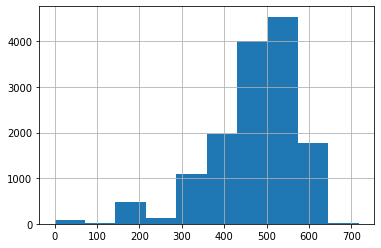

In [35]:
plt.hist(train['rougher.input.feed_rate'])
plt.grid()
plt.show()

In [36]:
train.loc[train['rougher.input.feed_rate'] < 75].head(5)

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-19 02:00:00,58.017871,15.273131,1.940663,7.25,0.180119,7.495765,0.992989,0.346667,40.044983,39.098614,3.331100,NaN,0.002655,NaN,NaN,26.275908
2016-01-30 16:00:00,2.080672,NaN,NaN,8.48,0.009179,10.283953,3.518852,0.510060,57.896229,29.273235,8.337111,0.424011,0.168260,0.161941,0.140785,76.837860
2016-02-13 03:00:00,55.733865,62.304511,10.857009,8.40,1.004522,9.070566,1.538998,0.312709,38.383671,29.705809,4.473913,2.224867,1.843385,2.266672,1.861447,73.296402
2016-02-17 19:00:00,54.119859,86.099027,12.454182,6.74,1.557107,8.452734,1.518000,16.229849,38.519760,18.349628,4.907203,2.961133,2.239939,2.975698,2.240781,78.099227
2016-03-02 11:00:00,0.463711,NaN,0.012373,7.62,0.001285,8.552262,1.613576,21.293760,27.619041,30.373428,4.132606,0.639700,0.004863,NaN,NaN,22.170429


Каких-либо необъяснимых аномалий в данных не найдено. Такое распределение вполне объяснимо особенностями процесса: выходом на рабочую скорость вращения механизма.

In [37]:
train.loc[train['rougher.input.feed_rate'].isna() == True].head(5)

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-21 10:00:00,74.257359,NaN,NaN,7.25,NaN,12.028591,4.203939,NaN,65.949829,41.782570,9.953463,NaN,NaN,NaN,NaN,86.217222
2018-02-21 00:59:59,78.303791,103.555658,4.798365,6.50,1.093272,8.138897,2.831503,NaN,44.732540,21.221039,7.605326,2.750448,1.769722,2.715050,1.771841,92.735216
2018-02-21 01:59:59,16.423530,NaN,0.135100,6.50,NaN,4.899445,1.961413,NaN,44.890770,0.463867,4.857160,NaN,0.009750,NaN,NaN,65.699544
2018-02-23 14:59:59,76.253850,108.766374,7.847694,7.69,1.349162,9.592977,5.217593,NaN,39.458908,40.273251,9.182248,7.945091,3.690531,7.950429,3.668673,95.001027
2018-03-29 11:59:59,59.781419,132.857240,3.764796,7.51,0.093886,7.924376,3.346301,NaN,35.553070,19.354876,7.571170,1.973431,0.819869,1.987143,0.789800,86.074228


Заполним отсутствующие данные в `rougher.input.feed_rate` следующим значением с помощью метода bfill

In [38]:
train['rougher.input.feed_rate'].bfill(inplace=True)
train['rougher.input.feed_rate'].isna().sum()

0

In [39]:
train['rougher.input.feed_rate'] = train['rougher.input.feed_rate'].astype('float32')
train['rougher.input.feed_rate'].dtype

dtype('float32')

**Признак rougher.input.feed_pb**

Для упрощения работы напишем функцию вывода необходимой информации для анализа на экран.

In [40]:
def analysis(table_name, col_name):
    display(table_name[col_name].sample(5))
    display(table_name[col_name].describe())
    display(table_name.loc[table_name[col_name].isna() == True].head(5))

И функцию для предобработки

In [41]:
def preprocessing(table_col, data_type):
    table_col.bfill(inplace=True)
    return table_col.astype(data_type)

In [42]:
analysis(train, 'rougher.input.feed_pb')

date
2017-02-07 06:59:59    3.420792
2016-03-02 03:00:00    3.267687
2018-05-18 19:59:59    4.210563
2018-08-17 09:59:59    4.757455
2018-06-06 10:59:59    3.901317
Name: rougher.input.feed_pb, dtype: float64

count    14049.000000
mean         3.522778
std          1.073394
min          0.010000
25%          2.780010
50%          3.422677
75%          4.226107
max          7.142594
Name: rougher.input.feed_pb, dtype: float64

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-31 10:00:00,40.604484,50.025824,4.951704,6.69,0.858775,7.504396,NaN,202.024292,60.125904,29.200848,3.514019,4.500554,2.616880,4.498548,2.617566,59.697364
2016-02-04 16:00:00,42.357525,132.427800,9.980541,7.31,1.495869,8.782859,NaN,411.555908,36.936359,30.523478,4.155161,6.966367,5.552877,6.970886,5.558286,60.412636
2016-02-27 19:00:00,68.950557,93.495886,6.724729,7.70,0.784433,7.146042,NaN,477.952637,54.936134,29.748333,3.682222,6.016813,3.638118,6.010129,3.641880,79.066540
2016-02-27 20:00:00,62.388421,61.967248,5.180330,7.70,0.625527,7.888903,NaN,492.788391,54.891903,33.534969,4.478027,5.501627,3.220578,5.495549,3.207587,82.260410
2016-03-03 18:00:00,29.387374,85.381617,9.467139,8.49,0.717046,7.551066,NaN,489.383453,49.991230,31.994877,3.691317,4.785527,3.095143,3.670072,2.551314,42.413734


In [43]:
train['rougher.input.feed_pb'] = preprocessing(train['rougher.input.feed_pb'], 'float32')

**Признак rougher.input.feed_ag**

In [44]:
analysis(train, 'rougher.input.feed_ag')

date
2018-01-13 08:59:59    13.124546
2016-06-27 20:59:59     9.075304
2016-04-03 11:00:00     6.779520
2016-02-01 02:00:00     8.244130
2018-05-19 02:59:59     6.678710
Name: rougher.input.feed_ag, dtype: float64

count    14149.000000
mean         8.579195
std          1.896284
min          0.010000
25%          7.132802
50%          8.156092
75%          9.918304
max         14.596026
Name: rougher.input.feed_ag, dtype: float64

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,


In [45]:
train['rougher.input.feed_ag'] = preprocessing(train['rougher.input.feed_ag'], 'float32')

**Признаки rougher.input.floatbank10_sulfate и rougher.input.floatbank11_sulfate**

In [46]:
analysis(train, 'rougher.input.floatbank10_sulfate')

date
2016-08-24 13:59:59     9.492990
2016-08-16 01:59:59    15.002854
2016-06-19 12:59:59    12.012640
2016-07-22 09:59:59    12.997370
2017-01-31 14:59:59    13.499663
Name: rougher.input.floatbank10_sulfate, dtype: float64

count    14120.000000
mean        11.764931
std          3.278813
min          0.001083
25%          9.861100
50%         11.688702
75%         13.607115
max         36.118275
Name: rougher.input.floatbank10_sulfate, dtype: float64

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-19 02:00:00,58.017871,15.273131,1.940663,7.25,0.180119,7.495765,0.992989,0.346667,40.044983,39.098614,3.331100,NaN,0.002655,NaN,NaN,26.275908
2016-01-21 10:00:00,74.257359,NaN,NaN,7.25,NaN,12.028591,4.203939,629.869568,65.949829,41.782570,9.953463,NaN,NaN,NaN,NaN,86.217222
2016-07-18 14:59:59,52.576792,62.830953,7.006670,8.21,0.574743,5.406940,1.765928,0.176529,28.450825,10.408539,5.058601,NaN,0.016077,NaN,NaN,87.152394
2017-03-17 07:59:59,49.803205,24.767205,2.364825,7.56,0.527468,9.128949,4.264464,0.188093,88.922966,29.329592,8.490030,NaN,0.017238,0.028810,NaN,76.409087
2017-07-13 20:59:59,43.234164,40.010587,2.198810,5.31,0.444120,5.896679,1.803820,200.950241,252.963226,21.166653,4.850341,NaN,0.005088,12.000707,5.200055,60.769985


Кажется логичным, заменить отсутствующее значение в столбце не предыдущим или последующим, а средним между ними. Попробуем это реализовать.

In [47]:
train['rougher.input.floatbank10_sulfate'] = (train['rougher.input.floatbank10_sulfate'].fillna(method='ffill') + 
                                              train['rougher.input.floatbank10_sulfate'].fillna(method='bfill')) / 2

In [48]:
train['rougher.input.floatbank10_sulfate'] = train['rougher.input.floatbank10_sulfate'].astype('float32')

In [49]:
analysis(train, 'rougher.input.floatbank11_sulfate')

date
2017-04-07 23:59:59    13.498806
2018-05-14 00:59:59     8.247118
2016-06-13 07:59:59    12.043487
2017-03-13 01:59:59     9.000584
2018-06-04 02:59:59     7.891811
Name: rougher.input.floatbank11_sulfate, dtype: float64

count    14113.000000
mean        11.368685
std          3.743672
min          0.000098
25%          9.505507
50%         11.384283
75%         13.497134
max         37.980648
Name: rougher.input.floatbank11_sulfate, dtype: float64

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-19 02:00:00,58.017871,15.273131,1.940663,7.25,0.180119,7.495765,0.992989,0.346667,40.044983,39.098614,3.331100,5.489133,0.002655,NaN,NaN,26.275908
2016-01-21 10:00:00,74.257359,NaN,NaN,7.25,NaN,12.028591,4.203939,629.869568,65.949829,41.782570,9.953463,19.682404,NaN,NaN,NaN,86.217222
2016-03-02 11:00:00,0.463711,NaN,0.012373,7.62,0.001285,8.552261,1.613576,21.293760,27.619041,30.373428,4.132606,0.639700,0.004863,NaN,NaN,22.170429
2016-05-15 14:59:59,45.586191,58.717323,12.027662,6.61,0.922359,10.871370,4.221773,388.148895,43.559513,29.605406,10.208728,7.968636,4.744994,NaN,NaN,9.826876
2016-07-18 14:59:59,52.576792,62.830953,7.006670,8.21,0.574743,5.406940,1.765928,0.176529,28.450825,10.408539,5.058601,12.553921,0.016077,NaN,NaN,87.152394


In [50]:
train['rougher.input.floatbank11_sulfate'] = (train['rougher.input.floatbank11_sulfate'].fillna(method='ffill') + 
                                              train['rougher.input.floatbank11_sulfate'].fillna(method='bfill')) / 2

In [51]:
train['rougher.input.floatbank11_sulfate'] = train['rougher.input.floatbank11_sulfate'].astype('float32')

<a name='sulfat'></a>
Распределения характеристик `rougher.input.floatbank10_sulfate` и `rougher.input.floatbank11_sulfate` кажутся похожими, проверим на гистограмме. Специально значения признаков нормировать не будем.

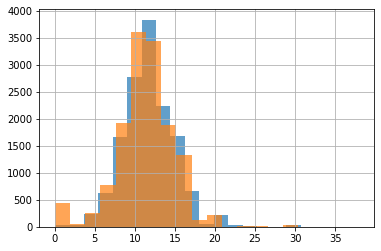

In [9]:
plt.figure()
plt.hist(train['rougher.input.floatbank10_sulfate'], bins=20, alpha=0.7)
plt.hist(train['rougher.input.floatbank11_sulfate'], bins=20, alpha=0.7)
plt.grid()
plt.show()

Из гистограммы видно явное совпадение распределений признаков `rougher.input.floatbank10_sulfate` и `rougher.input.floatbank11_sulfate`. Вполне возможно объединить оба признака в один при построении модели. Решим это на последующих этапах.

**Признак rougher.input.floatbank10_xanthate**

In [55]:
analysis(train, 'rougher.input.floatbank10_xanthate')

date
2018-04-29 12:59:59    7.502112
2016-05-19 02:59:59    5.601599
2016-07-10 15:59:59    5.298068
2017-08-29 00:59:59    5.402311
2016-03-27 07:00:00    6.499836
Name: rougher.input.floatbank10_xanthate, dtype: float64

count    14141.000000
mean         5.854529
std          1.104263
min          0.001428
25%          5.117359
50%          5.951071
75%          6.602533
max          9.703448
Name: rougher.input.floatbank10_xanthate, dtype: float64

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-21 10:00:00,74.257359,NaN,NaN,7.25,NaN,12.028591,4.203939,629.869568,65.949829,41.782570,9.953463,19.682404,NaN,19.661352,NaN,86.217222
2017-08-11 20:59:59,100.000000,NaN,NaN,6.94,NaN,7.973955,3.909912,1.687404,31.470755,38.813313,7.556612,0.580921,NaN,0.017116,NaN,83.406924
2017-08-11 21:59:59,100.000000,NaN,NaN,6.94,NaN,7.973955,3.909912,1.711558,34.919422,38.813313,7.556612,0.580921,NaN,0.014669,NaN,83.406924
2017-08-11 22:59:59,100.000000,NaN,NaN,6.94,0.007293,7.973955,3.909912,1.697448,35.259449,38.813313,7.556612,0.580921,NaN,0.016203,NaN,83.406924
2017-08-11 23:59:59,100.000000,NaN,NaN,6.94,NaN,7.973955,3.909912,1.726340,35.967930,38.813313,7.556612,0.580921,NaN,0.016170,NaN,83.406924


Попробуем другой метод заполнения отсуствующих данных, воспользовавшись методом interpolate

In [56]:
train['rougher.input.floatbank10_xanthate'].interpolate(inplace=True)

In [57]:
train['rougher.input.floatbank10_xanthate'] = train['rougher.input.floatbank10_xanthate'].astype('float32')

In [58]:
analysis(train, 'rougher.input.floatbank11_xanthate')

date
2017-04-13 05:59:59    4.598714
2016-02-12 03:00:00    7.638375
2017-07-28 08:59:59    4.799348
2017-03-30 03:59:59    5.303122
2017-01-29 07:59:59    4.999258
Name: rougher.input.floatbank11_xanthate, dtype: float64

count    13721.000000
mean         5.894176
std          1.124233
min          0.000290
25%          5.199168
50%          5.998460
75%          6.699006
max          9.698407
Name: rougher.input.floatbank11_xanthate, dtype: float64

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-19 02:00:00,58.017871,15.273131,1.940663,7.25,0.180119,7.495765,0.992989,0.346667,40.044983,39.098614,3.331100,5.489133,0.002655,7.513936,NaN,26.275908
2016-01-21 10:00:00,74.257359,NaN,NaN,7.25,NaN,12.028591,4.203939,629.869568,65.949829,41.782570,9.953463,19.682404,7.807699,19.661352,NaN,86.217222
2016-03-02 11:00:00,0.463711,NaN,0.012373,7.62,0.001285,8.552261,1.613576,21.293760,27.619041,30.373428,4.132606,0.639700,0.004863,4.101882,NaN,22.170429
2016-05-15 13:59:59,79.975380,159.551841,11.972081,7.74,0.904101,11.610162,4.383769,361.438080,42.144402,29.466625,10.899886,9.752428,5.418245,0.013842,NaN,40.346710
2016-05-15 14:59:59,45.586191,58.717323,12.027662,6.61,0.922359,10.871370,4.221773,388.148895,43.559513,29.605406,10.208728,7.968636,4.744994,4.242085,NaN,9.826876


In [59]:
train['rougher.input.floatbank11_xanthate'].interpolate(inplace=True)

In [60]:
train['rougher.input.floatbank11_xanthate'] = train['rougher.input.floatbank11_xanthate'].astype('float32')

<a name='xant'></a>
Данные признаки также очень похожи. Построим для них распределения без нормирования.

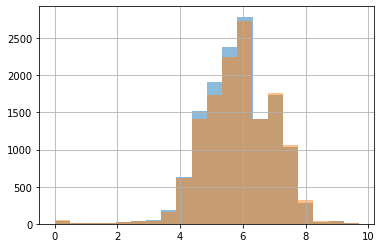

In [10]:
plt.figure()
plt.hist(train['rougher.input.floatbank10_xanthate'], bins=20, alpha=0.5)
plt.hist(train['rougher.input.floatbank11_xanthate'], bins=20, alpha=0.5)
plt.grid()
plt.show()

Здесь также наблюдается совпадение распределений. Возможно, признаки можно будет объединить в один. 

**Признак primary_cleaner.input.sulfate**

In [64]:
analysis(train, 'primary_cleaner.input.sulfate')

date
2018-08-11 14:59:59     80.399982
2018-02-06 09:59:59    198.059121
2016-07-27 18:59:59    100.560901
2017-01-29 11:59:59    215.147377
2018-02-01 14:59:59    154.503293
Name: primary_cleaner.input.sulfate, dtype: float64

count    14129.000000
mean       133.320659
std         39.431659
min          0.003112
25%        107.006651
50%        133.018328
75%        159.825396
max        250.127834
Name: primary_cleaner.input.sulfate, dtype: float64

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-21 10:00:00,74.257359,NaN,NaN,7.25,NaN,12.028591,4.203939,629.869568,65.949829,41.782570,9.953463,19.682404,7.807699,19.661352,7.787951,86.217222
2016-01-30 16:00:00,2.080672,NaN,NaN,8.48,0.009179,10.283953,3.518852,0.510060,57.896229,29.273235,8.337111,0.424011,0.168260,0.161941,0.140785,76.837860
2016-03-02 11:00:00,0.463711,NaN,0.012373,7.62,0.001285,8.552261,1.613576,21.293760,27.619041,30.373428,4.132606,0.639700,0.004863,4.101882,2.507766,22.170429
2016-06-30 19:59:59,100.000000,NaN,NaN,7.31,NaN,9.400717,2.264476,227.107819,49.636436,27.351177,6.925943,7.343456,3.837409,7.460771,3.733355,62.031307
2017-01-06 19:59:59,67.275195,NaN,0.416502,7.79,NaN,7.061728,5.038574,0.137877,46.128773,36.808594,8.518138,0.001613,0.007275,0.009350,5.077826,91.792293


In [65]:
train['primary_cleaner.input.sulfate'] = preprocessing(train['primary_cleaner.input.sulfate'], 'float32')

**Признак primary_cleaner.input.depressant**

In [66]:
analysis(train, 'primary_cleaner.input.depressant')

date
2018-06-29 23:59:59    6.956676
2018-03-22 17:59:59    9.971262
2017-03-23 23:59:59    7.333647
2016-08-28 17:59:59    6.461610
2017-08-25 01:59:59    5.520301
Name: primary_cleaner.input.depressant, dtype: float64

count    14117.000000
mean         8.866996
std          3.361589
min          0.000000
25%          6.040604
50%          8.035811
75%         11.522173
max         20.052255
Name: primary_cleaner.input.depressant, dtype: float64

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-21 10:00:00,74.257359,226.482605,NaN,7.250,NaN,12.028591,4.203939,629.869568,65.949829,41.782570,9.953463,19.682404,7.807699,19.661352,7.787951,86.217222
2016-01-30 16:00:00,2.080672,43.320038,NaN,8.480,0.009179,10.283953,3.518852,0.510060,57.896229,29.273235,8.337111,0.424011,0.168260,0.161941,0.140785,76.837860
2016-01-31 06:00:00,28.650801,43.320038,NaN,8.100,0.622271,7.988096,0.950353,200.653595,57.898579,31.262787,4.646736,3.997729,1.997800,4.000177,2.001097,63.786471
2016-01-31 07:00:00,39.020344,44.998230,NaN,8.100,0.680230,7.798316,0.833690,199.023239,57.903667,32.596508,4.508751,3.997914,2.000643,4.001125,2.006446,63.154615
2016-01-31 08:00:00,43.750736,49.131706,NaN,7.395,0.729487,7.506388,0.483542,198.982285,57.908756,35.657974,4.214522,4.319545,2.254216,4.321490,2.255912,62.519405


In [67]:
train['primary_cleaner.input.depressant'] = preprocessing(train['primary_cleaner.input.depressant'], 'float32')

**Признак primary_cleaner.input.feed_size**

In [68]:
analysis(train, 'primary_cleaner.input.feed_size')

date
2017-08-16 04:59:59    6.730000
2017-05-27 21:59:59    6.380000
2016-02-05 01:00:00    8.170000
2018-07-16 06:59:59    6.463333
2016-04-10 20:00:00    6.952000
Name: primary_cleaner.input.feed_size, dtype: float64

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,


In [69]:
train['primary_cleaner.input.feed_size'] = train['primary_cleaner.input.feed_size'].astype('float32')

**Признак primary_cleaner.input.xanthate**

In [70]:
analysis(train, 'primary_cleaner.input.xanthate')

date
2017-05-01 01:59:59    0.811617
2018-04-14 08:59:59    1.092553
2017-04-07 12:59:59    0.607408
2016-05-09 16:59:59    1.177024
2017-08-06 06:59:59    0.513358
Name: primary_cleaner.input.xanthate, dtype: float64

count    14049.000000
mean         0.885588
std          0.372714
min          0.000005
25%          0.607021
50%          0.888749
75%          1.100933
max          2.512968
Name: primary_cleaner.input.xanthate, dtype: float64

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2016-01-21 10:00:00,74.257359,226.482605,15.988715,7.25,NaN,12.028591,4.203939,629.869568,65.949829,41.782570,9.953463,19.682404,7.807699,19.661352,7.787951,86.217222
2016-03-24 08:00:00,56.583361,104.956421,11.999398,7.37,NaN,8.112402,2.607796,460.979736,46.861629,31.470762,7.164340,9.998693,6.233142,9.989479,6.235169,70.854239
2016-05-01 01:59:59,100.000000,4.494127,0.537326,8.40,NaN,8.580857,3.068290,366.807495,37.032722,34.825634,9.522819,4.499785,2.228831,4.497241,2.239721,70.412540
2016-06-30 19:59:59,100.000000,56.484303,5.794517,7.31,NaN,9.400717,2.264476,227.107819,49.636436,27.351177,6.925943,7.343456,3.837409,7.460771,3.733355,62.031307
2016-08-06 17:59:59,45.771200,39.212582,4.021451,6.96,NaN,8.633905,3.472412,298.355530,35.428947,18.154024,8.076979,7.999763,4.002704,7.997695,4.000540,69.057282


In [71]:
train['primary_cleaner.input.xanthate'] = preprocessing(train['primary_cleaner.input.xanthate'], 'float32')

**Признак rougher.output.recovery**

In [72]:
analysis(train, 'rougher.output.recovery')

date
2018-03-25 19:59:59    88.481341
2017-08-22 03:59:59    90.367104
2018-06-12 03:59:59    88.899312
2017-04-18 19:59:59    88.828352
2018-08-15 19:59:59    93.830551
Name: rougher.output.recovery, dtype: float64

count    14149.000000
mean        82.704502
std         14.479156
min          0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery, dtype: float64

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,


In [73]:
train.loc[train['rougher.output.recovery'] == 100]

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.recovery
date,,,,,,,,,,,,,,,,
2018-03-12 02:59:59,100.0,173.823059,7.965209,7.250000,1.095700,0.01,0.01,602.530090,80.935303,0.01,0.01,12.473083,7.004836,12.472844,7.000643,100.0
2018-03-12 03:59:59,100.0,173.810318,7.989731,7.250000,1.109543,0.01,0.01,609.936401,81.143700,0.01,0.01,12.465643,7.000502,12.469725,6.999049,100.0
2018-03-12 04:59:59,100.0,173.854584,8.010405,7.336667,1.097412,0.01,0.01,576.678284,80.105408,0.01,0.01,12.471164,6.994911,12.472203,7.002379,100.0
2018-03-12 05:59:59,100.0,173.840195,8.007879,7.380000,1.132049,0.01,0.01,584.285583,80.737541,0.01,0.01,12.479808,6.996583,12.471234,7.000732,100.0
2018-03-12 06:59:59,100.0,173.838623,8.013136,7.380000,1.100291,0.01,0.01,570.099487,76.291862,0.01,0.01,12.472951,6.999311,12.470497,7.003516,100.0


Вызывает вопросы стопроцентная эффективность обогащения. Разберемся с этим на последующих этапах.

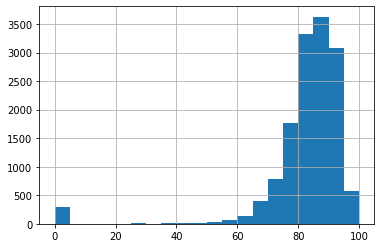

In [74]:
plt.figure()
plt.hist(train['rougher.output.recovery'], bins=20)
plt.grid()
plt.show()

In [75]:
train['rougher.output.recovery'] = train['rougher.output.recovery'].astype('float32')

In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   final.output.recovery               14149 non-null  float64
 1   primary_cleaner.input.sulfate       14149 non-null  float32
 2   primary_cleaner.input.depressant    14149 non-null  float32
 3   primary_cleaner.input.feed_size     14149 non-null  float32
 4   primary_cleaner.input.xanthate      14149 non-null  float32
 5   rougher.input.feed_ag               14149 non-null  float32
 6   rougher.input.feed_pb               14149 non-null  float32
 7   rougher.input.feed_rate             14149 non-null  float32
 8   rougher.input.feed_size             14149 non-null  float32
 9   rougher.input.feed_sol              14149 non-null  float32
 10  rougher.input.feed_au               14149 non-null  float32
 11  roughe

#### Таблица test

In [77]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   primary_cleaner.input.sulfate       5286 non-null   float64
 1   primary_cleaner.input.depressant    5285 non-null   float64
 2   primary_cleaner.input.feed_size     5290 non-null   float64
 3   primary_cleaner.input.xanthate      5286 non-null   float64
 4   rougher.input.feed_ag               5290 non-null   float64
 5   rougher.input.feed_pb               5290 non-null   float64
 6   rougher.input.feed_rate             5287 non-null   float64
 7   rougher.input.feed_size             5289 non-null   float64
 8   rougher.input.feed_sol              5269 non-null   float64
 9   rougher.input.feed_au               5290 non-null   float64
 10  rougher.input.floatbank10_sulfate   5285 non-null   float64
 11  rougher

Имея уже представление о значениях признаков в таблице train, заполним сразу все недостающие значения в таблице test методом interpolate.

In [78]:
test.interpolate(inplace=True)

In [79]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   primary_cleaner.input.sulfate       5290 non-null   float64
 1   primary_cleaner.input.depressant    5290 non-null   float64
 2   primary_cleaner.input.feed_size     5290 non-null   float64
 3   primary_cleaner.input.xanthate      5290 non-null   float64
 4   rougher.input.feed_ag               5290 non-null   float64
 5   rougher.input.feed_pb               5290 non-null   float64
 6   rougher.input.feed_rate             5290 non-null   float64
 7   rougher.input.feed_size             5290 non-null   float64
 8   rougher.input.feed_sol              5290 non-null   float64
 9   rougher.input.feed_au               5290 non-null   float64
 10  rougher.input.floatbank10_sulfate   5290 non-null   float64
 11  rougher

Исключим из ранее написанной функции analysis строку с поиском пустых значений.

In [80]:
def analysis(table_name, col_name):
    display(table_name[col_name].sample(5))
    display(table_name[col_name].describe())

**Признак primary_cleaner.input.sulfate**

In [81]:
analysis(test, 'primary_cleaner.input.sulfate')

date
2017-12-21 18:59:59    211.176019
2016-12-15 19:59:59    176.438064
2017-11-08 17:59:59    214.842479
2017-10-08 09:59:59    221.786344
2017-10-08 21:59:59    177.810555
Name: primary_cleaner.input.sulfate, dtype: float64

count    5290.000000
mean      174.793072
std        43.046684
min         2.566156
25%       147.071657
50%       177.821716
75%       208.112236
max       265.983123
Name: primary_cleaner.input.sulfate, dtype: float64

**Признак primary_cleaner.input.depressant**

In [82]:
analysis(test, 'primary_cleaner.input.depressant')

date
2017-12-31 16:59:59    16.006896
2016-10-24 10:59:59     5.511687
2017-10-07 14:59:59     6.058581
2017-10-27 18:59:59    13.972583
2017-11-26 10:59:59    11.006789
Name: primary_cleaner.input.depressant, dtype: float64

count    5290.000000
mean        8.683276
std         3.075199
min         0.003839
25%         6.489309
50%         8.052131
75%        10.028043
max        40.000000
Name: primary_cleaner.input.depressant, dtype: float64

**Признак primary_cleaner.input.feed_size**

In [83]:
analysis(test, 'primary_cleaner.input.feed_size')

date
2016-10-05 15:59:59    7.70
2016-10-13 20:59:59    8.08
2017-11-13 17:59:59    6.32
2017-09-10 01:59:59    7.02
2016-10-13 13:59:59    8.18
Name: primary_cleaner.input.feed_size, dtype: float64

count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

**Признак primary_cleaner.input.xanthate**

In [84]:
analysis(test, 'primary_cleaner.input.xanthate')

date
2016-11-17 11:59:59    1.294274
2017-11-09 00:59:59    1.740142
2017-10-27 22:59:59    2.041729
2017-12-03 16:59:59    2.305018
2017-10-30 02:59:59    1.887696
Name: primary_cleaner.input.xanthate, dtype: float64

count    5290.000000
mean        1.383293
std         0.643529
min         0.004984
25%         0.907390
50%         1.197562
75%         1.797698
max         4.102454
Name: primary_cleaner.input.xanthate, dtype: float64

**Признак rougher.input.feed_ag**

In [85]:
analysis(test, 'rougher.input.feed_ag')

date
2017-11-08 09:59:59     9.578664
2016-09-02 15:59:59     7.519734
2017-09-09 16:59:59     6.159347
2017-11-19 01:59:59    11.092526
2017-11-07 05:59:59    10.311035
Name: rougher.input.feed_ag, dtype: float64

count    5290.000000
mean        9.371940
std         1.926264
min         0.568441
25%         8.112434
50%         9.762654
75%        10.652297
max        14.406130
Name: rougher.input.feed_ag, dtype: float64

**Признак rougher.input.feed_pb**

In [86]:
analysis(test, 'rougher.input.feed_pb')

date
2017-12-26 19:59:59    5.393215
2016-10-19 10:59:59    4.235041
2016-12-12 20:59:59    3.960112
2016-10-26 09:59:59    2.530567
2017-11-13 20:59:59    3.043296
Name: rougher.input.feed_pb, dtype: float64

count    5290.000000
mean        3.798082
std         0.954859
min         0.273677
25%         3.240251
50%         3.740716
75%         4.282634
max         6.905684
Name: rougher.input.feed_pb, dtype: float64

В таблице нет подозрительно низких значений концентрации свинца как в таблице train.

**Признак rougher.input.feed_rate**

In [87]:
analysis(test, 'rougher.input.feed_rate')

date
2017-11-23 05:59:59    634.420060
2017-10-10 11:59:59    566.476474
2017-09-21 14:59:59    505.466040
2017-09-15 17:59:59    556.407234
2016-11-13 07:59:59    599.406079
Name: rougher.input.feed_rate, dtype: float64

count    5290.000000
mean      489.781470
std       108.036634
min         0.002986
25%       407.003619
50%       499.079325
75%       575.280388
max       707.364020
Name: rougher.input.feed_rate, dtype: float64

**Признак rougher.input.feed_size**

In [88]:
analysis(test, 'rougher.input.feed_size')

date
2017-11-15 20:59:59    76.177255
2017-10-20 11:59:59    62.120719
2017-12-14 06:59:59    72.169186
2017-10-21 06:59:59    55.700066
2017-09-26 13:59:59    63.729401
Name: rougher.input.feed_size, dtype: float64

count    5290.000000
mean       55.952835
std        19.080372
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

**Признак rougher.input.feed_sol**

In [89]:
analysis(test, 'rougher.input.feed_sol')

date
2016-10-25 12:59:59    34.972001
2016-12-30 01:59:59    35.190103
2016-11-11 08:59:59    32.109787
2016-11-04 14:59:59    34.973142
2017-10-19 06:59:59    40.159344
Name: rougher.input.feed_sol, dtype: float64

count    5290.000000
mean       37.700073
std         5.494787
min         1.393488
25%        34.483076
50%        37.956831
75%        41.619761
max        53.477742
Name: rougher.input.feed_sol, dtype: float64

В отличие от таблицы train в данной таблице в признаке `rougher.input.feed_sol` осутствуют подозрительные минимальные значения =0,01.

**Признак rougher.input.feed_au**

In [90]:
analysis(test, 'rougher.input.feed_au')

date
2016-12-25 10:59:59    10.335487
2016-12-31 06:59:59     9.133165
2016-12-15 14:59:59     9.810487
2017-10-22 04:59:59    10.997277
2016-11-03 18:59:59     6.430644
Name: rougher.input.feed_au, dtype: float64

count    5290.000000
mean        9.334682
std         1.619521
min         0.568632
25%         8.207814
50%         9.593766
75%        10.463538
max        13.731330
Name: rougher.input.feed_au, dtype: float64

Аналогично в признаке `rougher.input.feed_au` данной таблицы осутствуют подозрительные минимальные значения =0,01.

**Признак rougher.input.floatbank10_sulfate**

In [91]:
analysis(test, 'rougher.input.floatbank10_sulfate')

date
2016-12-20 05:59:59    14.997622
2017-11-03 04:59:59    16.997550
2016-12-28 21:59:59    10.000008
2016-11-12 10:59:59    12.001453
2016-11-10 01:59:59    12.002264
Name: rougher.input.floatbank10_sulfate, dtype: float64

count    5290.000000
mean       13.852214
std         3.352756
min         0.001147
25%        11.994929
50%        14.002932
75%        16.972136
max        24.280636
Name: rougher.input.floatbank10_sulfate, dtype: float64

**Признак rougher.input.floatbank10_xanthate**

In [92]:
analysis(test, 'rougher.input.floatbank10_xanthate')

date
2017-10-19 02:59:59    7.087629
2016-10-20 02:59:59    6.542264
2016-12-08 22:59:59    6.120833
2016-10-02 08:59:59    6.399196
2017-11-28 14:59:59    8.000966
Name: rougher.input.floatbank10_xanthate, dtype: float64

count    5290.000000
mean        6.467745
std         1.065114
min         0.000568
25%         5.998779
50%         6.498181
75%         7.085457
max         8.910468
Name: rougher.input.floatbank10_xanthate, dtype: float64

**Признак rougher.input.floatbank11_sulfate**

In [93]:
analysis(test, 'rougher.input.floatbank11_sulfate')

date
2017-12-05 12:59:59    16.342898
2017-10-21 23:59:59    23.000762
2016-09-21 14:59:59     7.999628
2017-10-31 10:59:59    16.998229
2016-11-06 01:59:59    13.999614
Name: rougher.input.floatbank11_sulfate, dtype: float64

count    5290.000000
mean       13.903588
std         3.258107
min         0.000077
25%        11.996921
50%        14.004106
75%        16.953537
max        24.280966
Name: rougher.input.floatbank11_sulfate, dtype: float64

**Признак rougher.input.floatbank11_xanthate**

In [94]:
analysis(test, 'rougher.input.floatbank11_xanthate')

date
2017-09-21 04:59:59    6.902586
2016-12-06 22:59:59    5.901476
2016-10-26 03:59:59    5.998584
2017-12-29 02:59:59    7.002179
2016-11-11 04:59:59    7.000481
Name: rougher.input.floatbank11_xanthate, dtype: float64

count    5290.000000
mean        6.497801
std         0.910915
min         0.006985
25%         5.998904
50%         6.498428
75%         7.087476
max         8.621338
Name: rougher.input.floatbank11_xanthate, dtype: float64

Приведем значения в таблице к более оптимальным типам данных

In [95]:
test = test.astype('float32')

In [96]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   primary_cleaner.input.sulfate       5290 non-null   float32
 1   primary_cleaner.input.depressant    5290 non-null   float32
 2   primary_cleaner.input.feed_size     5290 non-null   float32
 3   primary_cleaner.input.xanthate      5290 non-null   float32
 4   rougher.input.feed_ag               5290 non-null   float32
 5   rougher.input.feed_pb               5290 non-null   float32
 6   rougher.input.feed_rate             5290 non-null   float32
 7   rougher.input.feed_size             5290 non-null   float32
 8   rougher.input.feed_sol              5290 non-null   float32
 9   rougher.input.feed_au               5290 non-null   float32
 10  rougher.input.floatbank10_sulfate   5290 non-null   float32
 11  rougher

#### Таблица full_data

Заполним аналогичным образом недостающие данные в таблице full_data

In [97]:
full_data.interpolate(inplace=True)

Анализ данных в таблице full_data проведем в рамках следующего этапа. Там же попробуем ответить на вопросы, возникшие на этапе предобработки данных таблицы train.

### Вывод

На этапе подготовки данных был проведен первичный анализ данных. Проведена проверка значений признака эффективность обогащения. Также было проведено сопоставление признаков в обучающей и тестовой таблице. На основе него из таблицы train были удалены признаки, отсутствовавшие в таблице test. Кроме того, из таблиц был удалены признаки, не влияющие на построение модели. В процессе предобработки данных были заполнены отсутствующие значения, для чего использовались различные варианты реализации этого процесса. Были выявлены некоторые закономерности и аномалии в данных, которые будут проверены на следующем этапе.

## Анализ данных

### Концентрация металлов

На исходных данных посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Для вывода графиков напишем функцию, которая на вход будет принимать датасет и обозначение металла, входящее в название всех признаков, характеризующих его концентрацию (pb, au, ag). В самой функции определен датафрейм, содержащий названия признаков без обозначения металла, которое передается на вход фунцкии, название этапа и цвет графика. Для удобства сравнения на каждом графике выводится 2 гистограммы распределения. Графики, относящиеся к одному этапу, имеют один и тот же цвет.

In [98]:
def func_graph(data, metal):
    table_process = pd.DataFrame(data=[['rougher.input.feed_', 'Исходное сырье','red'], 
                                       ['rougher.output.concentrate_', 'После флотации', 'blue'],
                                       ['primary_cleaner.output.concentrate_', 'После первичной очистки', 'green'],
                                       ['final.output.concentrate_', 'После вторчной очистки', 'brown']],
                                 columns=['stage', 'stage_label', 'stage_color'])
    
    fig = plt.figure()
    for i in range(len(table_process) - 1):
        axes = fig.add_subplot(1, 3, i+1)
        data[table_process.loc[i, 'stage'] + metal].plot(kind='hist', bins=20, alpha=0.6, 
                    color=table_process.loc[i, 'stage_color'], label=table_process.loc[i, 'stage_label'], legend=True, ax=axes)
        data[table_process.loc[i + 1, 'stage'] + metal].plot(kind='hist', bins=20, alpha=0.6, 
                    color=table_process.loc[i + 1, 'stage_color'], label=table_process.loc[i + 1, 'stage_label'], legend=True)
        
        plt.grid()
        axes.set_title("Распределение концентрации металла", fontsize=14)
        axes.set_xlabel("Концентрация металла", fontsize=12)
        axes.set_ylabel("Количество измерений", fontsize=12)
        
        
    fig.set_figwidth(18)
    fig.set_figheight(6)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    box = plt.boxplot(data.loc[:, table_process['stage'] + metal], vert=False, patch_artist=True, 
                      medianprops={"color": "black", "linewidth": 1.5}, whiskerprops={"linewidth": 2}, 
                      boxprops={"linewidth": 1.5}, labels=table_process['stage_label'])
    
    for patch, color in zip(box['boxes'], table_process['stage_color']):
        patch.set_facecolor(color)
    
    plt.title('Диаграмма размаха для концентрации металла по этапам очистки', fontsize=14)
    plt.xlabel('Концентрация металла', fontsize=12)
    plt.grid()
    plt.show()


#### Свинец (pb)

Построим графики распределения концентрации для свинца.

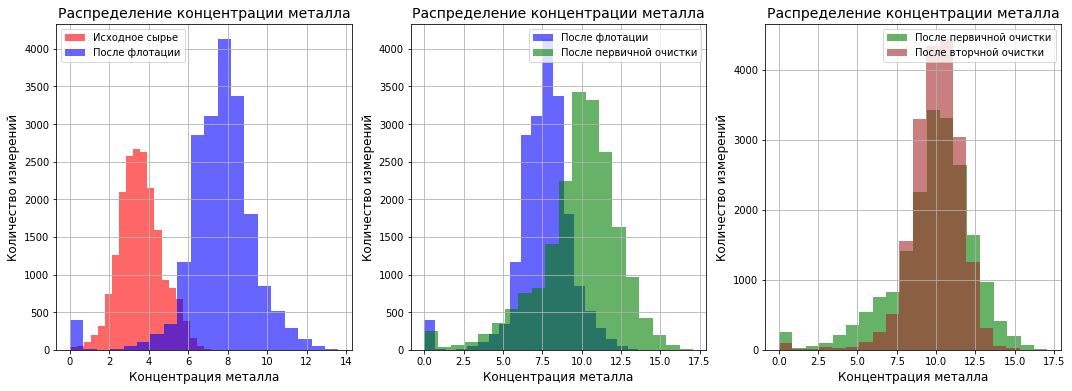

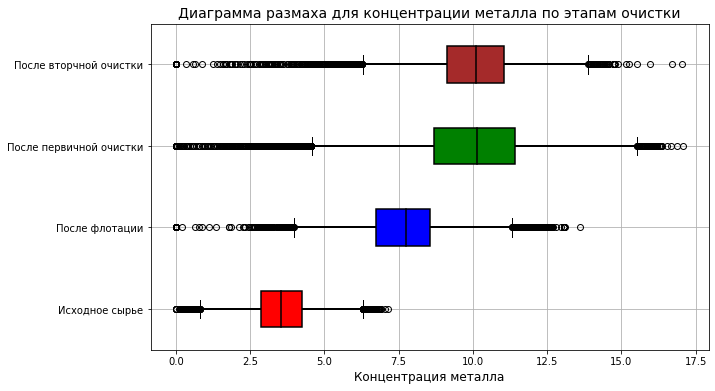

In [99]:
func_graph(full_data, 'pb')

Анализируя полученные гистограммы, можно сказать, что по мере прохождения сырья через этапы очистки гистограммы распределения смещаются вправо, т.е. увеличивается среднее содержание металла в породе. За исключением последнего этапа. На последнем этапе медианное значение концентрации свинца остается примерно таким же как и до этого этапа. Однако, по уменьшившемуся межквартильному размаху можно судить о том, что уменьшился разброс значений, т.е. 50% всех измеренных значений лежит в меньшем диапазоне чем до последнего этапа чистки. Об этом же говорят высокие пики на последней гистограмме: в сумме около 8750 таких измерений. Также стоит отметить наличие значений концентрации, близких к нулю, на каждом из графиков распределения, т.е. поле каждого этапа очистки. Это, скорее всего, аномальные значения, от которых стоит избавиться.

#### Золото (au)

Построим графики распределения конценрации для золота

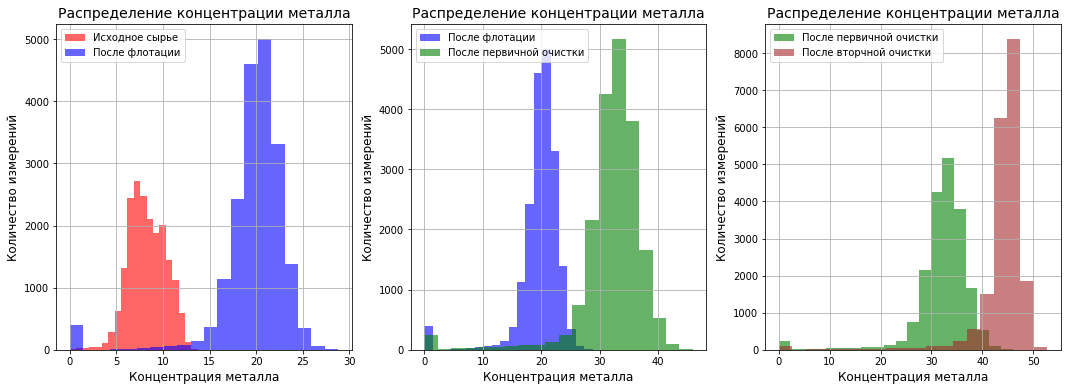

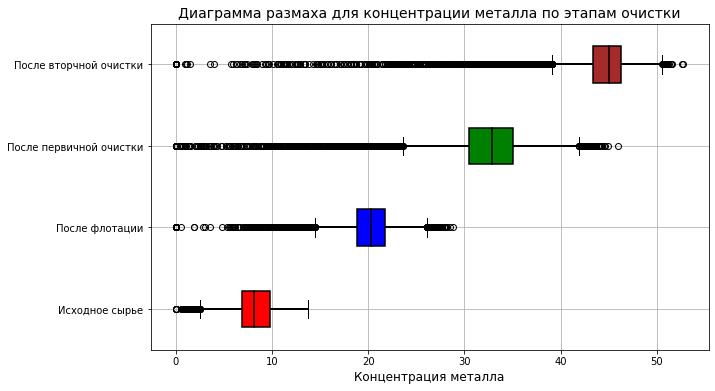

In [100]:
func_graph(full_data, 'au')

По золоту прослеживается аналогичная со свинцом ситуация. До вторичной очистки разброс значений концентрации металла растет, после второй очистки разброс в диапазоне межквартильного размаха уменьшается, т.е. 50% значений измерений лежит в более узком интервале примерно от 42,5 до 47. Это около 14200 измерений. Стоит заметить, что распределение концентрации золота после вторичной очистки характеризуется большим левым хвостом (значениями с небольшой концентрацией). Кроме того, бросается в глаза, что медианное значение концентрации золота от исходного сырья до этапа после второй очистки увеличилось примерно в 5 раз, а для свинца - всего в 3 раза, что объясняется целью самого процесса (получение золота). Отметим также, что, как и для свинца, на графиках распределения концентрации золота присутствуют аномальные значения, близкие к нулю. 

#### Серебро (ag)

Построим графики распределения концентрации серебра

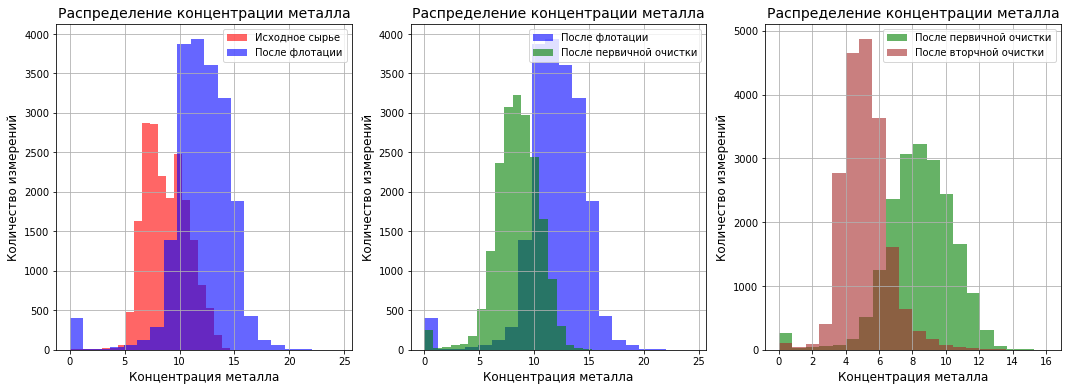

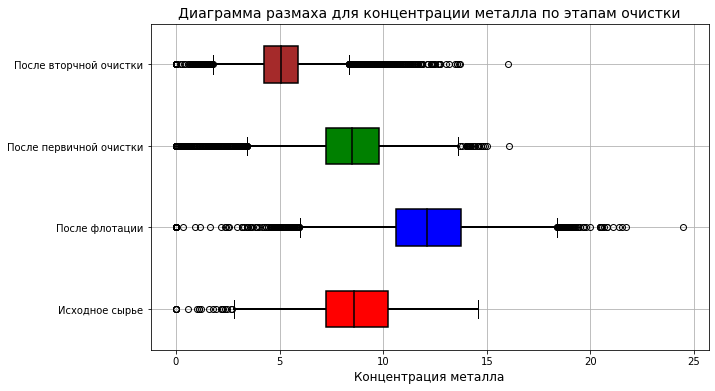

In [101]:
func_graph(full_data, 'ag')

По серебру наблюдается иная тенденция: после этапа флотации медианное значение концентарции растет (гистограмма распределения смещается вправо), а на последующих этапах оно начинает уменьшаться (гистограмма распределения смещается влево). Если после этапа первичной очистки медианное значение стало примерно таким же как в исходном сырье, то после вторичной очистки медианное начение концентрации стало еще меньше: во входном сырье - около 8 единиц, после этапа вторичной очистки - 5 единиц. Видимо, большое количество серебра уходит вместе с хвостами. Но, стоит отметить, что как и для свинца с золотом, интервал межквартильного размаха также непрерывно уменьшается, начиная от входного сырья и получения итогового продукта на выходе. Аномальные близкие к нулю значения концентрации серебра также присутствуют на всех графиках распределения. Устранением аномалий займемся на последнем этапе данного раздела.

### Размер гранул сырья

Для сравнения построим графики распределения признака "Размер гранул входного сырья" `rougher.input.feed_size` для обучающей и тестовой выборок. Для чистоты эксперимента добавим на график еще распределение размера гранул сырья исходной выборки. Графики нормализуем с помощью атрибута density=True.

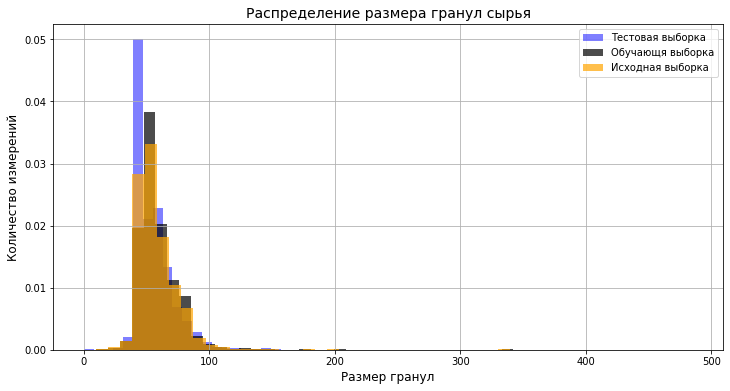

In [102]:
plt.figure(figsize=(12, 6))
test['rougher.input.feed_size'].plot(kind='hist', bins=50, alpha=0.5, color='blue', label='Тестовая выборка', 
                                     legend=True, density=True)
train['rougher.input.feed_size'].plot(kind='hist', bins=50, alpha=0.7, color='black', label='Обучающя выборка', 
                                      legend=True, density=True)
full_data['rougher.input.feed_size'].plot(kind='hist', bins=50, alpha=0.7, color='orange', label='Исходная выборка', 
                                          legend=True, density=True)

plt.grid()
plt.title("Распределение размера гранул сырья", fontsize=14)
plt.xlabel("Размер гранул", fontsize=12)
plt.ylabel("Количество измерений", fontsize=12)
        
plt.show()

По графикам распределения видим, что гистограммы для всех трех выборок близки к нормальным и очень похожи друг на друга: практически вписываются друг в друга. Если бы распределения обучающей и тестовой выборок сильно отличались, это бы означало, что выборки сформированы некорректно, к примеру, данные были взяты неслучайно из исходной выборки. В данном случае все корректно, можно строить модель.

### Суммарная концентрация всех веществ

<a name='anomal'></a> Рассчитаем суммарную концентрацию металлов на каждом из этапов очистки и построим графики распределения.

<Figure size 432x288 with 0 Axes>

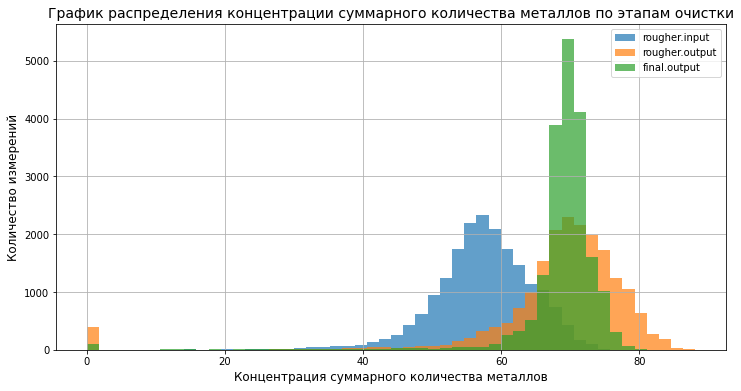

In [103]:
full_data['rougher.input'] = (full_data['rougher.input.feed_ag'] +
    full_data['rougher.input.feed_pb'] + full_data['rougher.input.feed_au'] + full_data['rougher.input.feed_sol'])

full_data['rougher.output'] = (full_data['rougher.output.concentrate_ag'] +
    full_data['rougher.output.concentrate_pb'] + full_data['rougher.output.concentrate_au'] + 
                                   full_data['rougher.output.concentrate_sol'])

full_data['final.output'] = (full_data['final.output.concentrate_ag'] +
    full_data['final.output.concentrate_pb'] + full_data['final.output.concentrate_au'] + 
                                   full_data['final.output.concentrate_sol'])

plt.figure()
full_data.loc[:, 'rougher.input' : 'final.output'].plot(kind='hist', bins=50, alpha=0.7, figsize=(12, 6))

plt.grid()
plt.title('График распределения концентрации суммарного количества металлов по этапам очистки', fontsize=14)
plt.xlabel('Концентрация суммарного количества металлов', fontsize=12)
plt.ylabel('Количество измерений', fontsize=12)
plt.show()

На графике видно, что в выборках присутствуют аномально низкие значения концентрации, близкие к нулю. Это вызывает вопросы, т.к. в сырье должно наличиствовать хотя бы какое-то количество металлов, отличное от нуля, учитывая, что на графике отображено суммарное количество по всем металлам. Причем эти значения характерны для всех этапов очистки. Скорее всего, произошел какой-то сбой в измерении. Для дальнейшего построения моделей необходимо избавиться от этих аномалий. Займемся этим на следующем этапе.

### Подготовка выборок

#### Отбор по суммарной концентрации металлов

Избавимся от аномалий, обнаруженных на предыдущем этапе, во всех таблицах. Посмотрим сначала сколько таких строк в исходной таблице.

In [104]:
full_data.loc[full_data['final.output'] == 0]['final.output'].count()

98

In [105]:
(full_data['final.output'] == 0).count()

19439

Выберем в обучающей и тестовой выборках все строки, индексы которых совпадают с индексами строк исходной выборки, где у нас получилась нулевая сумма концентраций металлов после финального этапа очистки и удалим эти строки. В исходной таблице также удалим эти строки.

In [106]:
train.drop(train.loc[full_data['final.output'] == 0].index, axis=0, inplace=True)
test.drop(test.loc[full_data['final.output'] == 0].index, axis=0, inplace=True)
full_data.drop(full_data.loc[full_data['final.output'] == 0].index, axis=0, inplace=True)

In [107]:
full_data.loc[full_data['rougher.output'] == 0]['rougher.output'].count()

392

Проведем аналогичную процедуру по столбцу `rougher.output` с нулевыми значениями для всех наших таблиц. В исходной таблице таких строк оказалось 392.

In [108]:
train.drop(train.loc[full_data['rougher.output'] == 0].index, axis=0, inplace=True)
test.drop(test.loc[full_data['rougher.output'] == 0].index, axis=0, inplace=True)
full_data.drop(full_data.loc[full_data['rougher.output'] == 0].index, axis=0, inplace=True)

Проверим, остались ли строки с аномальныи значенями в столбце `rougher.input`

In [109]:
full_data.loc[full_data['rougher.input'] == 0]['rougher.input'].count()

0

Больше таких строк нет в исходной таблице, значит их нет и в обучающей и тестовой выборках. Проверим, осталось ли минимальное значение концентрации золота `rougher.output.recovery` =0.01 и вызвавшее у нас подозрение, в таблице train.

In [110]:
train['rougher.output.recovery'].describe()

count    13795.000000
mean        84.505005
std          7.984405
min          2.520854
25%         80.374115
50%         85.518250
75%         90.289516
max        100.000000
Name: rougher.output.recovery, dtype: float64

Вопрос о минимальном значении концентрации золота решился сам собой в процессе устранения аномалий по другим признакам. 

#### Отбор по эффективности очистки

Ранее мы обращали внимание на подозрительные значения эффективности очистки после этапа флотации, равные 100%. Посмотрим еще раз на эти строки.

In [111]:
full_data.loc[full_data['rougher.output.recovery'] == 100]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,rougher.input,rougher.output,final.output
date,,,,,,,,,,,,,,,,,,,,,
2018-03-12 02:59:59,5.413548,9.389648,8.731319,45.270618,100.0,0.0,0.0,0.0,0.0,173.823067,...,0.633728,20.904297,1.352458,0.0,0.0,0.0,0.0,0.04,0.04,68.805134
2018-03-12 03:59:59,5.413548,9.389648,8.731319,45.270618,100.0,0.0,0.0,0.0,0.0,173.810317,...,0.633728,20.904297,1.352458,0.0,0.0,0.0,0.0,0.04,0.04,68.805134
2018-03-12 04:59:59,5.413548,9.389648,8.731319,45.270618,100.0,0.0,0.0,0.0,0.0,173.854586,...,0.633728,20.904297,1.352458,0.0,0.0,0.0,0.0,0.04,0.04,68.805134
2018-03-12 05:59:59,5.413548,9.389648,8.731319,45.270618,100.0,0.0,0.0,0.0,0.0,173.840200,...,0.633728,20.904297,1.352458,0.0,0.0,0.0,0.0,0.04,0.04,68.805134
2018-03-12 06:59:59,4.238007,7.349108,6.833999,35.424183,100.0,0.0,0.0,0.0,0.0,173.838628,...,0.495861,20.904297,1.352458,0.0,0.0,0.0,0.0,0.04,0.04,53.845297


Согласно формуле это достигается только при нулевых значениях количества добываемого металла в хвостах. Однако, это возможно только теоретически. На практике невозможно достигнуть таких результатов. Кроме того, в этих строках смущают нулевые значения количества металлов в хвостах. Это, вероятно, и стало причиной появления расчетного значения эффекивности =100%. Удалим эти аномалии из наших таблиц.

In [112]:
train.loc[full_data['rougher.output.recovery'] == 100]['rougher.output.recovery'].count()

5

In [113]:
train.drop(train.loc[full_data['rougher.output.recovery'] == 100].index, axis=0, inplace=True)

В тестовой выборке таких строк нет, т.к. все они в количестве =5 оказались в тренировочной выборке. Удалим их и из исходной таблицы.

In [114]:
full_data.drop(full_data.loc[full_data['rougher.output.recovery'] == 100].index, axis=0, inplace=True)

На том же основании посмотрим, есть ли и сколько в исходной таблице находится строк со стопроцентной итоговой эффективностью.

In [115]:
full_data.loc[full_data['final.output.recovery'] == 100]['final.output.recovery'].count()

85

In [116]:
full_data.loc[full_data['final.output.recovery'] == 100].head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,rougher.input,rougher.output,final.output
date,,,,,,,,,,,,,,,,,,,,,
2016-01-18 05:00:00,4.392827,10.611895,3.769994,46.543285,100.0,0.0,0.0,0.0,0.0,157.532385,...,0.414353,33.817076,2.310386,0.000000,0.000000,0.000000,0.000000,56.853148,61.044909,65.318001
2016-04-20 11:00:00,5.829191,7.802456,11.447054,25.773495,100.0,0.0,0.0,0.0,0.0,63.014436,...,0.629738,14.528143,1.996220,12.913498,4.451667,7.076441,5.356954,53.392531,74.664446,50.852195
2016-04-20 22:00:00,5.957068,11.112426,16.058054,42.984047,100.0,0.0,0.0,0.0,0.0,135.081971,...,0.730604,22.567908,1.471380,10.856210,3.593789,10.811096,3.248157,63.705067,68.086012,76.111595
2016-05-01 01:59:59,5.774070,11.079094,8.151890,38.456209,100.0,0.0,0.0,0.0,0.0,4.494127,...,0.952270,11.044614,3.860953,14.805406,4.508542,10.943635,11.957084,54.336830,78.910400,63.461263
2016-06-30 18:59:59,6.977900,6.462480,10.321985,42.718150,100.0,0.0,0.0,0.0,0.0,0.129139,...,0.232717,15.167583,1.560134,13.666059,1.712074,10.920029,4.233605,41.945314,68.164712,66.480515


Как и в случае с признаком `rougher.output.recovery` здесь расчетное значение итоговой эффективности получилось из-за нулевых значений концентрации металлов в хвостах. Также удалим эти строки из наших таблиц как содержащие аномалии.

In [117]:
train.loc[full_data['final.output.recovery'] == 100]['rougher.output.recovery'].count()

69

In [118]:
train.drop(train.loc[full_data['final.output.recovery'] == 100].index, axis=0, inplace=True)

In [119]:
test.loc[full_data['final.output.recovery'] == 100]['rougher.input.feed_au'].count()

16

In [120]:
test.drop(test.loc[full_data['final.output.recovery'] == 100].index, axis=0, inplace=True)
full_data.drop(full_data.loc[full_data['final.output.recovery'] == 100].index, axis=0, inplace=True)

#### Отбор по концентрации золота на выходе

Просмотрим признаки, содержащие значения концентрации золота в выходых данных, на предмет наличия аномалий:
- `final.output.concentrate_au`
- `final.output.tail_au`
- `rougher.output.concentrate_au`
- `rougher.output.tail_au`

In [121]:
full_data['rougher.output.tail_au'].sample(5)

date
2016-12-27 14:59:59    2.494937
2017-07-18 04:59:59    2.308598
2016-04-02 22:00:00    1.316726
2018-04-24 11:59:59    0.975640
2017-02-12 10:59:59    1.873448
Name: rougher.output.tail_au, dtype: float64

In [122]:
full_data['rougher.output.tail_au'].describe()

count    18859.000000
mean         1.809493
std          0.674729
min          0.020676
25%          1.399205
50%          1.801099
75%          2.205825
max          9.688980
Name: rougher.output.tail_au, dtype: float64

In [123]:
full_data['rougher.output.concentrate_au'].tail()

date
2018-08-18 06:59:59    18.603550
2018-08-18 07:59:59    18.441436
2018-08-18 08:59:59    15.111231
2018-08-18 09:59:59    17.834772
2018-08-18 10:59:59    17.804134
Name: rougher.output.concentrate_au, dtype: float64

In [124]:
full_data['rougher.output.concentrate_au'].describe()

count    18859.000000
mean        20.189199
std          2.439447
min          0.570819
25%         18.927700
50%         20.328356
75%         21.752791
max         28.824507
Name: rougher.output.concentrate_au, dtype: float64

Вопросов к `rougher.output.tail_au` и `rougher.output.concentrate_au` нет.

In [125]:
full_data['final.output.tail_au'].sample(5)

date
2016-03-13 22:00:00    2.564063
2016-12-21 20:59:59    2.376688
2017-03-23 01:59:59    3.293088
2016-07-25 17:59:59    2.951089
2016-11-21 09:59:59    3.476687
Name: final.output.tail_au, dtype: float64

In [126]:
full_data['final.output.tail_au'].describe()

count    18859.000000
mean         3.046212
std          0.894570
min          0.005462
25%          2.463370
50%          2.978412
75%          3.557403
max          8.245022
Name: final.output.tail_au, dtype: float64

In [127]:
full_data['final.output.concentrate_au'].sample(5)

date
2018-07-19 00:59:59    47.745747
2017-08-11 12:59:59    46.663126
2016-08-17 21:59:59    44.679004
2016-11-18 05:59:59    47.977104
2017-05-07 08:59:59    44.969463
Name: final.output.concentrate_au, dtype: float64

In [128]:
full_data['final.output.concentrate_au'].describe()

count    18859.000000
mean        44.299862
std          3.978903
min          0.010000
25%         43.424532
50%         45.008166
75%         46.260297
max         52.756638
Name: final.output.concentrate_au, dtype: float64

Кажется сомнительным минимальное значение концентрации золота =0.01. Посмотрим на строки таблицы рядом с этим значением.

In [129]:
full_data.loc[full_data['final.output.concentrate_au'] < 1]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,rougher.input,rougher.output,final.output
date,,,,,,,,,,,,,,,,,,,,,
2017-12-17 10:59:59,2.876804,2.877504,2.64565,0.904254,4.591076,9.276926,1.420174,3.563024,4.164522,53.850882,...,0.964173,16.866951,2.404312,15.011763,7.624817,3.625809,15.931242,39.090349,78.658359,9.304212
2018-05-15 04:59:59,0.010000,0.010000,0.01000,0.010000,0.168611,8.069722,1.734258,5.262840,2.452356,15.095571,...,0.062855,21.779297,0.935019,13.410405,5.730321,1.632719,3.832578,9.514401,12.490444,0.040000


Такая строка всего одна, и в ней, подозрительно совпадают значения концентрации золота, свинца, серебра и сольвента =0.01. Такое совпадение маловероятно, т.е. оно являеся аномалией. Удалим эту строку из таблиц.

In [130]:
test.drop(full_data.loc[full_data['final.output.concentrate_au'] == .01].index, axis=0, inplace=True)
full_data.drop(full_data.loc[full_data['final.output.concentrate_au'] == .01].index, axis=0, inplace=True)

In [131]:
full_data.loc[full_data['final.output.concentrate_pb'] < 1]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,rougher.input,rougher.output,final.output
date,,,,,,,,,,,,,,,,,,,,,
2017-11-04 23:59:59,0.434375,0.893524,0.706414,3.911529,75.966464,3.337462,1.121304,3.360135,1.435228,7.025591,...,0.035022,15.639648,2.490158,3.096228,1.103268,0.616309,0.546029,8.072476,18.856160,5.945843
2018-05-15 04:59:59,0.010000,0.010000,0.010000,0.010000,0.168611,8.069722,1.734258,5.262840,2.452356,15.095571,...,0.062855,21.779297,0.935019,13.410405,5.730321,1.632719,3.832578,9.514401,12.490444,0.040000


In [132]:
full_data[['final.output.concentrate_au', 'final.output.tail_au', 'rougher.output.concentrate_au', 
           'rougher.output.tail_au']] = full_data[['final.output.concentrate_au', 'final.output.tail_au', 
                            'rougher.output.concentrate_au', 'rougher.output.tail_au']].astype('float32')

#### Отбор по реагентам

Как ранее было отмечено признаки, характеризующие концентрацию сульфата `rougher.input.floatbank10_sulfate`, `rougher.input.floatbank11_sulfate` и ксантогената `rougher.input.floatbank11_xanthate`, `rougher.input.floatbank10_xanthate`во флотационных утановках №10 и №11 имеют одинаковые распределения. Учитывая, что в физическом смысле признаки описывают влияние одного и того же параметра  на процесс очистки, разделенного на 2 входных канала, их можно объединить в один, тем более единицы измерения они имеют одни и те же. Объединим эти признаки простым суммированием. 

In [133]:
train['rougher.input_sulfate'] = train['rougher.input.floatbank10_sulfate'] + train['rougher.input.floatbank10_sulfate']
test['rougher.input_sulfate'] = test['rougher.input.floatbank10_sulfate'] + test['rougher.input.floatbank10_sulfate']

train['rougher.input_xanthate'] = train['rougher.input.floatbank10_xanthate'] + train['rougher.input.floatbank10_xanthate']
test['rougher.input_xanthate'] = test['rougher.input.floatbank10_xanthate'] + test['rougher.input.floatbank10_xanthate']

#### Выделение выборок

Сформируем тренировочную и тестовую выборки с входными признаками. Целевая метрика у нас фактически состоит из двух частей   $sMAPE_{roougher}$   и   $sMAPE_{final}$,  дающих оценку очистки после этапа флотации и итоговую. На этапе флотации на очистку не воздействуют признаки, подключающиеся к процессу на этапе первичной очистки: `primary_cleaner.input.sulfate, primary_cleaner.input.depressant, primary_cleaner.input.feed_size, primary_cleaner.input.xanthate`. Соотвественно, мы не можем их включить в набор признаков для разработки модели процесса флотации. Они могут быть включены в полную модель, описывающую полностью весь процесс и оцениваемую метрикой $sMAPE_{final}$. Поэтому нам потребуется два набора признаков, влияющих на процесс: для этапа флотации и полностью для всего процесса.

In [134]:
train_features_rougher = train.drop(['rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
                           'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 
                           'rougher.output.recovery', 'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
                            'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'final.output.recovery'], axis=1)

train_features_final = train.drop(['rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
                           'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 
                           'rougher.output.recovery', 'final.output.recovery'], axis=1)

In [135]:
test_features_rougher = test.drop(['rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
                           'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 
                           'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
                            'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate'], axis=1)

test_features_final = test.drop(['rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
                           'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate'], axis=1)

In [136]:
train_features_rougher.columns

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input_sulfate', 'rougher.input_xanthate'],
      dtype='object')

In [137]:
train_features_final.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input_sulfate', 'rougher.input_xanthate'],
      dtype='object')

In [138]:
test_features_rougher.columns

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input_sulfate', 'rougher.input_xanthate'],
      dtype='object')

In [139]:
test_features_final.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input_sulfate', 'rougher.input_xanthate'],
      dtype='object')

Так как целевая метрика у нас фактически состоит из двух частей   $sMAPE_{roougher}$   и   $sMAPE_{final}$,   дающих оценку по отдельному этапу очистки, соответственно, нам потребуется два набора целевых признаков. 

In [140]:
train_target_rougher = full_data.loc[train.index]['rougher.output.recovery']
test_target_rougher = full_data.loc[test.index]['rougher.output.recovery']

In [141]:
train_target_final = full_data.loc[train.index]['final.output.recovery']
test_target_final = full_data.loc[test.index]['final.output.recovery']

Характеристики `final.output.concentrate_au`, `final.output.tail_au`, `rougher.output.concentrate_au`, `rougher.output.tail_au`, если потребуется, будем брать непосредственно из таблицы full_data.

#### Масштабирование

Так как на данном этапе непонятно, на каком типе моделей мы остановимся, сразу проведем масштабирование признаков, хотя для некоторых моделей эта процедура может быть избыточной. 

In [142]:
scaler = StandardScaler()

scaler.fit(train_features_final[train_features_final.columns.to_list()])
train_features_final[train_features_final.columns.to_list()] = (
    scaler.transform(train_features_final[train_features_final.columns.to_list()])
)

test_features_final[test_features_final.columns.to_list()] = (
    scaler.transform(test_features_final[test_features_final.columns.to_list()])
)

   
scaler.fit(train_features_rougher[train_features_rougher.columns.to_list()])
train_features_rougher[train_features_rougher.columns.to_list()] = (
    scaler.transform(train_features_rougher[train_features_rougher.columns.to_list()])
)
    
test_features_rougher[test_features_rougher.columns.to_list()] = (
    scaler.transform(test_features_rougher[test_features_rougher.columns.to_list()])
)

### Вывод

На данном этапе иссследования был проведен анализ значений признаков, которые в дальнейшем будут использованы для построения и оценки моделей. По результатам анализа были выявлены аномалии, которые были успешно удалены из наших выборок. Кроме того, в окончательном виде были сформированы тестовая и тренировочная выборки для построения/тестирования модели, а также сформированы 2 таблицы с целевыми признаками, проведено масштабирование признаков. 

## Модель

### Функция для расчета sMAPE

Напишем функцию для расчета итогового $sMAPE$ 

In [143]:
def smape(y_target, y_predict):
    
    smape = (abs(y_target - y_predict)) / ((abs(y_target) + abs(y_predict)) / 2)
    return smape.mean()

In [144]:
def smape_total(smape_rougher, smape_final):
    smape_total = .25 * smape_rougher + .75 * smape_final
    return smape_total

### Разработка моделей 

#### Модель Дерево решений

<a name='p52'></a>Создадим специальную таблицу, куда будем сохранять метрики и парамеры моделей.

In [145]:
model_metric = pd.DataFrame(index=['smape_rougher', 'smape_final', 'smape_total', 'max_depth_rougher', 
                                   'max_depth_final', 'estimators_rougher', 'estimators_final'], columns=['Tree', 'RF', 'LR'])

Построим модель Дерево решений для этапа флотации на обучающей выборке. Для подбора параметров модели и задействования кроссвалидации воспользуемся инструментом GridSearchCV из пакета sklearn.model_selection

In [146]:
model = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth' : range(1, 10)}
grid = GridSearchCV(model, parameters, scoring=make_scorer(smape, greater_is_better=False), cv=5)
grid.fit(train_features_rougher, train_target_rougher)

model_metric.loc['smape_rougher', 'Tree'] = abs(grid.best_score_)
model_metric.loc['max_depth_rougher', 'Tree'] = grid.best_params_['max_depth']

А теперь для процесса очистки в целом

In [147]:
grid.fit(train_features_final, train_target_final)

model_metric.loc['smape_final', 'Tree'] = abs(grid.best_score_)
model_metric.loc['max_depth_final', 'Tree'] = grid.best_params_['max_depth']

Рассчитаем значение итоговой метрики

In [148]:
model_metric.loc['smape_total', 'Tree'] = smape_total(model_metric.loc['smape_rougher', 'Tree'], 
                                                      model_metric.loc['smape_final', 'Tree'])

In [149]:
model_metric

,Tree,RF,LR
smape_rougher,0.065321,NaN,NaN
smape_final,0.092002,NaN,NaN
smape_total,0.085332,NaN,NaN
max_depth_rougher,5,NaN,NaN
max_depth_final,3,NaN,NaN
estimators_rougher,NaN,NaN,NaN
estimators_final,NaN,NaN,NaN


Для этапа флотации модель Дерево решений показала качество модели $sMAPE_{rougher} = $6,53% с максимальной глубиной дерева =5 и для всего процесса $sMAPE_{final} = $9,2% с максимальной глбиной дерева =3. Итоговая метрика качества $sMAPE_{total} = $8,53%.

#### Модель Случайный лес

Построим модель Случайный лес

In [150]:
model = RandomForestRegressor(random_state=12345)
parameters = {'max_depth' : range(5, 20), 'n_estimators' : range(25, 35)}
grid = GridSearchCV(model, parameters, scoring=make_scorer(smape, greater_is_better=False), cv=5)
grid.fit(train_features_rougher, train_target_rougher)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(5, 20),
                         'n_estimators': range(25, 35)},
             scoring=make_scorer(smape, greater_is_better=False))

In [151]:
model_metric.loc['smape_rougher', 'RF'] = abs(grid.best_score_)
model_metric.loc['max_depth_rougher', 'RF'] = grid.best_params_['max_depth']
model_metric.loc['estimators_rougher', 'RF'] = grid.best_params_['n_estimators']

In [152]:
model = RandomForestRegressor(random_state=12345)
parameters = {'max_depth' : range(2, 4), 'n_estimators' : range(53, 60)}
grid = GridSearchCV(model, parameters, scoring=make_scorer(smape, greater_is_better=False), cv=5)
grid.fit(train_features_final, train_target_final)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(2, 4),
                         'n_estimators': range(53, 60)},
             scoring=make_scorer(smape, greater_is_better=False))

In [153]:
model_metric.loc['smape_final', 'RF'] = abs(grid.best_score_)
model_metric.loc['max_depth_final', 'RF'] = grid.best_params_['max_depth']
model_metric.loc['estimators_final', 'RF'] = grid.best_params_['n_estimators']

In [154]:
model_metric.loc['smape_total', 'RF'] = smape_total(model_metric.loc['smape_rougher', 'RF'], 
                                                      model_metric.loc['smape_final', 'RF'])

In [155]:
model_metric

,Tree,RF,LR
smape_rougher,0.065321,0.062898,NaN
smape_final,0.092002,0.089634,NaN
smape_total,0.085332,0.08295,NaN
max_depth_rougher,5,7,NaN
max_depth_final,3,3,NaN
estimators_rougher,NaN,28,NaN
estimators_final,NaN,56,NaN


Модель Случайный лес показало себя лучше модели Дерево решений. Метрика для этапа флотации при максимальной глубие дерева =7 и количестве деревьев =28 составляет $sMAPE_{rougher} = $6,29%, а для всего процесса очистки при глубине дерева =3 и количестве деревьев =56 $sMAPE_{final} = $8,96%. Значение итоговой метрики $sMAPE_{total}$ также оказалось меньше =8,29%

#### Модель линейной регрессии

Для построения модели линейной регрессии вопользуемся методом cross_val_score, который также позволяет нам осуществить кроссвалидацию.

In [156]:
model = LinearRegression()
model_metric.loc['smape_rougher', 'LR'] = abs(cross_val_score(model, train_features_rougher, 
            train_target_rougher, scoring=make_scorer(smape, greater_is_better=False), cv=5).mean())
model_metric.loc['smape_final', 'LR'] = abs(cross_val_score(model, train_features_final, 
            train_target_final, scoring=make_scorer(smape, greater_is_better=False), cv=5).mean())

In [157]:
model_metric.loc['smape_total', 'LR'] = smape_total(model_metric.loc['smape_rougher', 'LR'], 
                                                      model_metric.loc['smape_final', 'LR'])

In [158]:
model_metric

,Tree,RF,LR
smape_rougher,0.065321,0.062898,0.06284
smape_final,0.092002,0.089634,0.092795
smape_total,0.085332,0.08295,0.085306
max_depth_rougher,5,7,NaN
max_depth_final,3,3,NaN
estimators_rougher,NaN,28,NaN
estimators_final,NaN,56,NaN


В итоге видим, что модель Линейная регрессия на этапе флотации показала результат лучше чем модель Случайный лес: $sMAPE_{rougher} = $6,28% против $sMAPE_{rougher} = $6,29%. Однако, для полного процесса очистки данная модель дала результат хуже Случайного леса, всего $sMAPE_{final} = $9,28%. Итоговая оценка качества также оказалась хуже $sMAPE_{total} = $8,53%. Таким образом, для проверки на тестовых данных отбираем модель Линейная регрессия для этапа флотации и модель Случайный лес для всего процесса очистки.

#### Тестирование моделей

Протестируем выбранные модели на тестовых выборках.

In [159]:
model = LinearRegression()
model.fit(train_features_rougher, train_target_rougher)
predict_rougher = model.predict(test_features_rougher)
smape_rougher_test = smape(test_target_rougher, predict_rougher)

In [160]:
smape_rougher_test

0.04262604279649532

На тестовых данных для этапа флотации Линейная регрессия показала даже лучший результат чем на обучающей выборке $sMAPE_{rougher} = $4,26%. Проверим на тестовой выборке модель Случайный лес для всего процесса очистки, используя найденные оптимальные параметры: максимальная глубина дерева =3 и количество деревьев =56.

In [161]:
model = RandomForestRegressor(random_state=12345, n_estimators=model_metric.loc['estimators_final', 'RF'], 
                              max_depth=model_metric.loc['max_depth_final', 'RF'])
model.fit(train_features_final, train_target_final)
predict_final = model.predict(test_features_final)
smape_final_test = smape(test_target_final, predict_final)

In [162]:
smape_final_test

0.07680293819140542

In [163]:
smape_total_test = smape_total(smape_rougher_test, smape_final_test)
smape_total_test

0.06825871434267788

Для всего процесса очистки на тестовых данных модель Случайный лес также показала лучший результат по сравнению с обучающей выборкой, $sMAPE_{final} = $7,68%. Очевидно, что результирующая оценка качества также получилась лучшей $sMAPE_{total}$ = 6,83%.

#### Адекватность модели

Проверим адекватность выбранных моделей с помощью метода DummyRegressor.

In [164]:
model = DummyRegressor()
model.fit(train_features_rougher, train_target_rougher)
predict_dummy = model.predict(test_features_rougher)
smape_rougher_dummy = smape(test_target_rougher, predict_dummy)
smape_rougher_dummy

0.05384148695934339

Полученное значение метрики $sMAPE_{rougher} = $5,38% больше того, что показала модель Линейная регрессия.

In [165]:
model.fit(train_features_final, train_target_final)
predict_dummy = model.predict(test_features_final)
smape_final_dummy =smape(test_target_final, predict_dummy)
smape_final_dummy

0.08574929745429531

Полученное значение метрики $sMAPE_{final} = $8,57% больше того, что показала модель Случайный лес.

In [166]:
smape_total(smape_rougher_dummy, smape_final_dummy)

0.07777234483055732

Метрики для константных моделей оказались хуже чем для найденных нами моделей, поэтому можно утверждать, что модели Линейная регрессия для этапа флотации и Случайный лес для всего процесса очистки вполне адекватны.

### Альтернативные варианты разработки моделей

В данном подразделе в учебных целях рассматриваются альтернативные варианты некоторых решений, принятых в процессе решения задачи (см.выше).

#### Использование байесовской оптимизации

Для подбора гиперпарметров можно воспользоваться методом байесовской оптимизации, для чего загрузим соответствующий пакет. 

In [166]:
!pip install hyperopt

     |████████████████████████████████| 1.6 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 57.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 55.5 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=68b2c97b0ab7a167ce63bbb7996eeb81fc1e8a21b5503ff42ea1f61253b8b914
  Stored in directory: /home/jovyan/.cache/pip/wheels/2f/a0/d3/4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
Successfully built future


Используем данный метод при подборе гиперпараметров модели Случайный лес

In [167]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import numpy as np
from functools import partial

Определим пространство параметров.

In [168]:
space ={
    'max_depth': hp.choice("max_depth", np.arange(1, 9, dtype=int)),
    'n_estimators': hp.choice("n_estimators", np.arange(50, 60, dtype=int)),
}

In [186]:
def hyperopt_score(params, x_train, y_train):
    model = RandomForestRegressor(**params, random_state=12345)
    current_score = abs(cross_val_score(model, x_train, y_train, 
                                        scoring=make_scorer(smape, greater_is_better=False), cv=5).mean())

    return current_score

Запустим функцию на тренировочной выборке для этапа флотации.

In [187]:
best = fmin(fn=partial(hyperopt_score, x_train=train_features_rougher, 
                       y_train=train_target_rougher), space=space, algo=tpe.suggest, max_evals=10)

100%|██████████| 10/10 [01:03<00:00,  6.39s/trial, best loss: 0.06301479612888192]


In [188]:
best

{'max_depth': 6, 'n_estimators': 5}

Полученное оптимальное значение количества деревьев разительно отличается от значения, полученного методом GridSearchCV: 5 против 23. Найдем значения гиперпараметров для всего цикла очистки.

In [189]:
best = fmin(fn=partial(hyperopt_score, x_train=train_features_final, 
                       y_train=train_target_final), space=space, algo=tpe.suggest, max_evals=20)

100%|██████████| 20/20 [03:55<00:00, 11.79s/trial, best loss: 0.08967653459811359]


In [190]:
best

{'max_depth': 2, 'n_estimators': 7}

Значение гиперпараметра количество деревьев также сильно отличается от полученного методом GridSearchCV: 7 против 56. Рассчитаем итоговую метрику.

In [194]:
smape_total(0.06301479612888192, 0.08967653459811359)

0.08301109998080566

Вполне предсказуемо, значение итоговой метрики получилось чуть хуже. Самое интересное, проверить модель с полученными данным методом гиперпараметрами на тестовых данных. Проверим модель только на выборке по всему процессу, по которой найденный гиперпараметры вызывают наибольшие вопросы.

In [191]:
model = RandomForestRegressor(random_state=12345, n_estimators=7, max_depth=2)
model.fit(train_features_final, train_target_final)
predict_final = model.predict(test_features_final)
smape_final_test_1 = smape(test_target_final, predict_final)

In [192]:
smape_final_test_1

0.07505719500900031

На тестовых данных при найденых методом байесовской оптимизации гиперпараметрах значение оценки $sMAPE_{final}$ =7,51% оказалось даже ниже чем при гиперпараметрах, найденых методом GridSearchCV, где $sMAPE_{final}$ =7.68%.

#### Использование multioutput-модели

Ранее в предыдущем разеле разрабатывались модели исходя из упрощения, что входные признаки, содержащиеся в выборке train_target_rougher действуют независимо на модели, описывающие этап флотации и весь процесс в целом. Кроме того, на весь процесс в целом воздействовали уникальные признаки из train_target_final: `primary_cleaner.input.sulfate`, `primary_cleaner.input.depressant`, `primary_cleaner.input.feed_size`, `primary_cleaner.input.xanthate`. 

Для решения данной задачи возможен другой подход с допущением, что все входные признаки, в том числе уникальные из выборки  train_target_final, воздействуют сразу на весь процесс очистки. Но кроме них на конечный целевой признак train_target_final воздействует полученный целевой признак после этапа флотации train_target_rougher. Это вполне согласуется с физическим процессом, т.к. на самом деле на оставшиеся после флотации этапы очистки воздействуют не входные признаки из выборки train_target_final, а признаки, полученные после этапа флотации: `rougher.output.tail_au` и `rougher.output.concentrate_au`. Согласно формуле данные признаки оказывают влияние на целевой признак train_target_rougher, поэтому вполне правомерно предположить, что пресказываемое значение данного целевого признака оказывает влияние на весь оставшийся процесс очистки.

Сделав эти допущения, мы можем воспользоваться для построения модели методом RegressorChain, который позволяет выстраивать цепь моделей.

In [154]:
from sklearn.multioutput import RegressorChain

Сформируем общий датафрейм с целевыми признаками.

In [152]:
train_target = pd.DataFrame()
train_target['rougher'] = train_target_rougher
train_target['final'] = train_target_final

С помощью атрибута order зададим порядок: первая модель обучается на основе независимых значений входных признаков, а вторая модель - на основе независимых значений входных признаков и значения второй зависимой переменной (целевого признака train_target_rougher).

In [172]:
model = LinearRegression()
chain = RegressorChain(model, order=[0, 1], random_state=12345, cv=5)
predict_data = chain.fit(train_features_final, train_target).predict(test_features_final)

In [173]:
smape_total(smape(test_target_rougher, predict_data[:,0]), smape(test_target_final, predict_data[:,1]))

0.07665974068412001

На тестовых данных ошибка $sMAPE_{total}$=7,67% получилась больше, что, скорее всего, связано с изначальным допущением при построении модели, что признаки `primary_cleaner.input.sulfate`, `primary_cleaner.input.depressant`, `primary_cleaner.input.feed_size`, `primary_cleaner.input.xanthate` действуют полностью на весь процесс очистки. Кроме того, использование другой изначальной модели типа Случайный лес могло дать луший результат.

### Вывод

На данном этапе были созданы функции для расчета метрик по этапам очистки $sMAPE$ и итоговой $sMAPE_{total}$. Для этапов очистки флотация и весь процесс очистки, оценка качества по каждому из которых входит в итоговую оценку $sMAPE_{total}$, было разработано три модели предсказания: Дерево решений, Случайный лес, Линейная регрессия. Для этапа флотации наилучший результат показала модель Линейная регрессия, а для всего процесса очистки - модель Случайный лес. На тестовых данных выбранные модели дали лучший результат в сравнении с результатами на обучающей выборке. На тестовой выборке значение итоговой метрики $sMAPE_{total}$ составляет 6,83%. Тест на адекватность данные модели также прошли. 

## Выводы

В рамках исследования решалась задача поиска моделей предсказания для процесса очистки золота. На предварительном этапе из исходных выборок были исключены лишние признаки, которые не могли участвовать в построении моделей. Также был проведен предварителный анализ признаков в тренировочной выборке, выявлен ряд закономерностей в данных и некоторые аномалии. На следующем этапе в процессе более подробного анализа, на основе построенных распределений по этапамочистки были выялены аномалии в признаках с концентрацией металлов, а также суммарной концентрации металлов. Строки, в которых содержались измерения с аномальными зачениями были удалены из исходных таблиц. Кроме того, были объединены два признака, характеризующих концентрацию сульфата и два признака по ксантогенату, ввиду наличия мультиколлинеарнсти. Также на данном этапе тестовая и обучающая выборки были приведены к окончательному виду. Каждая из них была разделена на две части, так как на этап флотации и весь процесс очистки в целом воздействует разный их набор. Предполагая, что влияние признаков на процесс очистки равнозначно, признаки в выборках были отмасштабированы. На следующем этапе для каждого из этапов очистки были построены модели предсказания: Дерево решений, Случайный лес и Линейная регрессия. Для подбора параметров моделей использовался инструмент GridSearchCV. Использоване метода кросс-валидации в процессе подбора позволило одновременно проверить данные модели и подобрать наиболее оптимальые параметры. Наилучший результат по метрике sMAPE для этапа флотации показал модель Линейная регрессия, для всего процесса очистки в целом - модель Случайный лес. На тестовых данных выбраные модели показали результат лучше чем на обучающей выборке. Проверка на адекватность моделей таже прошла успешно.